In [3]:
import pandas as pd
import tensorflow as tf

In [4]:
# Set seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
import os

# Ensure reproducibility by configuring deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
df = pd.read_csv('data.csv')

In [6]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,4600.0,551962.99,563834.70,0.0,322875.00,460943.46,654962.50,26590000.0
bedrooms,4600.0,3.40,0.91,0.0,3.00,3.00,4.00,9.0
bathrooms,4600.0,2.16,0.78,0.0,1.75,2.25,2.50,8.0
sqft_living,4600.0,2139.35,963.21,370.0,1460.00,1980.00,2620.00,13540.0
sqft_lot,4600.0,14852.52,35884.44,638.0,5000.75,7683.00,11001.25,1074218.0
floors,4600.0,1.51,0.54,1.0,1.00,1.50,2.00,3.5
waterfront,4600.0,0.01,0.08,0.0,0.00,0.00,0.00,1.0
view,4600.0,0.24,0.78,0.0,0.00,0.00,0.00,4.0
condition,4600.0,3.45,0.68,1.0,3.00,3.00,4.00,5.0
sqft_above,4600.0,1827.27,862.17,370.0,1190.00,1590.00,2300.00,9410.0


In [7]:
df.drop(columns=['country', 'street'], inplace=True)
for col in ['bedrooms', 'bathrooms', 'floors']:
    df[col] = df[col].apply(lambda x:int(x))

df['date'] = pd.to_datetime(df['date'])
df['year_sold'] = df['date'].dt.year
df['month_sold'] = df['date'].dt.month
df['day_sold'] = df['date'].dt.day
df = df.drop(columns=['date'])
df = pd.get_dummies(df, columns=['city', 'statezip'], drop_first=True)
df['house_age'] = df['year_sold'] - df['yr_built']
df['years_since_renovation'] = df['year_sold'] - df['yr_renovated']
df['years_since_renovation'] = df['years_since_renovation'].apply(lambda x: x if x >= 0 else 0)
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
df['total_sqft'] = df['sqft_living'] + df['sqft_lot']

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Example using MinMaxScaler
scaler = MinMaxScaler()
numerical_features = ['sqft_living', 'sqft_lot', 'floors', 'waterfront',
                      'view', 'condition', 'sqft_above', 'sqft_basement',
                      'yr_built', 'yr_renovated', 'year_sold', 'month_sold',
                      'day_sold', 'house_age', 'years_since_renovation', 'total_sqft']

df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\renat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
history = model.fit(X_train, y_train,
                    epochs=300,              # Maximum number of epochs
                    batch_size=64,           # Size of mini-batches
                    validation_split=0.2,    # Validation data split
                    callbacks=[early_stopping])  # Include the EarlyStopping callback


Epoch 1/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 453873827840.0000 - mae: 543999.7500 - val_loss: 401507418112.0000 - val_mae: 536806.6250
Epoch 2/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 453860327424.0000 - mae: 543988.4375 - val_loss: 401463607296.0000 - val_mae: 536768.5000
Epoch 3/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 453796069376.0000 - mae: 543934.2500 - val_loss: 401333452800.0000 - val_mae: 536654.8125
Epoch 4/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 453628297216.0000 - mae: 543792.5625 - val_loss: 401061117952.0000 - val_mae: 536417.1875
Epoch 5/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 453297963008.0000 - mae: 543513.3125 - val_loss: 400587259904.0000 - val_mae: 536003.0000
Epoch 6/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 452742873088.0000 - mae: 543043.3750 - val_loss: 399850471424.0000 - val_mae: 535358.6250
Epoch 7/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 451901489152.0000 - mae: 542330.0625 - val_loss

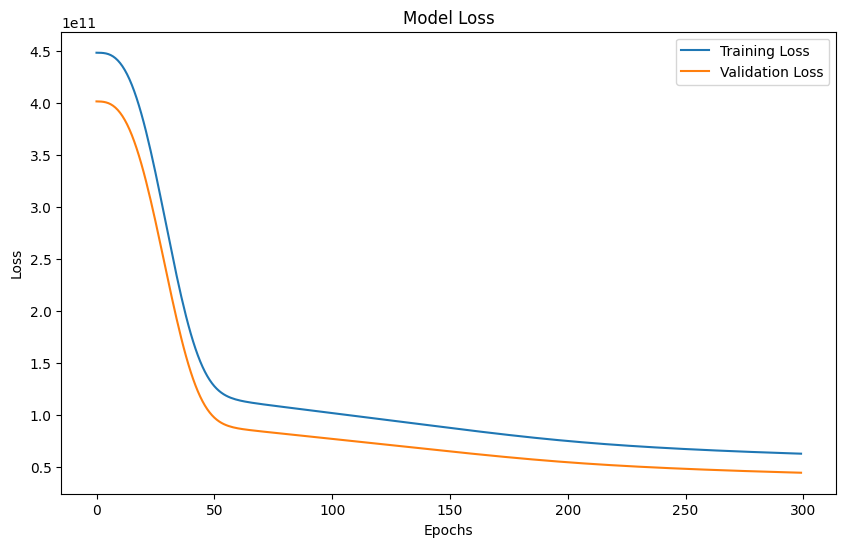

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(False)
plt.show()

In [11]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 180787068928.0000 - mae: 153784.1250
Test MAE: 177758.921875


In [12]:
X_test

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,statezip_WA 98178,statezip_WA 98188,statezip_WA 98198,statezip_WA 98199,statezip_WA 98288,statezip_WA 98354,house_age,years_since_renovation,has_basement,total_sqft
3683,3,2,0.082764,0.000908,0.5,0.0,0.00,0.50,0.089602,0.058091,...,False,False,False,False,False,False,0.061404,1.000000,1,0.001534
4411,5,2,0.123766,0.006764,0.0,0.0,0.00,0.75,0.102876,0.145228,...,False,True,False,False,False,False,0.245614,1.000000,1,0.007880
2584,3,3,0.195140,0.004465,1.0,0.0,0.75,0.75,0.228982,0.103734,...,False,False,False,False,False,False,0.315789,0.006951,1,0.006459
69,3,2,0.138952,0.006252,0.0,0.0,0.00,1.00,0.132743,0.130705,...,False,False,False,False,False,False,0.228070,1.000000,1,0.007554
1844,3,2,0.102506,0.007561,0.0,0.0,0.00,0.50,0.069690,0.149378,...,False,False,False,False,False,False,0.271930,0.002483,1,0.008414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,3,1,0.100987,0.007230,0.0,0.0,0.00,0.50,0.120575,0.049793,...,False,False,False,True,False,False,0.587719,0.000993,1,0.008066
1068,5,2,0.118451,0.005106,0.0,0.0,0.00,0.50,0.172566,0.000000,...,False,False,False,False,False,False,0.640351,0.022344,0,0.006160
4350,3,2,0.061503,0.006665,0.0,0.0,0.00,0.75,0.089602,0.000000,...,False,False,False,False,False,False,0.192982,1.000000,0,0.007018
3027,4,2,0.151860,0.008798,0.5,0.0,0.00,1.00,0.221239,0.000000,...,False,False,False,False,False,False,0.421053,1.000000,0,0.010253


In [13]:
X_test.iloc[0]

bedrooms                         3
bathrooms                        2
sqft_living               0.082764
sqft_lot                  0.000908
floors                         0.5
                            ...   
statezip_WA 98354            False
house_age                 0.061404
years_since_renovation         1.0
has_basement                     1
total_sqft                0.001534
Name: 3683, Length: 138, dtype: object

In [14]:
X_test.iloc[0].values.reshape(1, -1)

array([[3, 2, 0.08276385725132879, 0.0009081763818252948, 0.5, 0.0, 0.0,
        0.5, 0.08960176991150443, 0.058091286307053944,
        0.938596491228072, 0.0, 0.0, 0.5, 0.9666666666666667, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, True, False,
        False, False, F

In [15]:
X_test.iloc[0]

bedrooms                         3
bathrooms                        2
sqft_living               0.082764
sqft_lot                  0.000908
floors                         0.5
                            ...   
statezip_WA 98354            False
house_age                 0.061404
years_since_renovation         1.0
has_basement                     1
total_sqft                0.001534
Name: 3683, Length: 138, dtype: object

In [10]:
import pandas as pd
import numpy as np

# Single house data
house = {
    'date': '2023-08-31',
    'bedrooms': 3,
    'bathrooms': 2,
    'sqft_living': 1800,
    'sqft_lot': 10000,
    'floors': 1,
    'waterfront': 0,
    'view': 0,
    'condition': 3,
    'sqft_above': 1800,
    'sqft_basement': 0,
    'yr_built': 2020,
    'yr_renovated': 0,
    'city': 'Seattle',
    'statezip': 'WA 98125'
}

# Convert to DataFrame
house_df = pd.DataFrame([house])

# Preprocess the date
house_df['date'] = pd.to_datetime(house_df['date'])
house_df['year_sold'] = house_df['date'].dt.year
house_df['month_sold'] = house_df['date'].dt.month
house_df['day_sold'] = house_df['date'].dt.day

# Feature engineering
house_df['house_age'] = house_df['year_sold'] - house_df['yr_built']
house_df['years_since_renovation'] = house_df['year_sold'] - house_df['yr_renovated']
house_df['years_since_renovation'] = house_df['years_since_renovation'].apply(lambda x: x if x >= 0 else 0)
house_df['total_sqft'] = house_df['sqft_living'] + house_df['sqft_lot']
house_df['has_basement'] = house_df['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)

# Drop unnecessary columns
house_df = house_df.drop(columns=['date', 'yr_built', 'yr_renovated'])

# One-hot encoding for categorical features
house_df = pd.get_dummies(house_df, columns=['city', 'statezip'], drop_first=True)

# Ensure the single input has the same features as the training data
# Assuming X_train was your original training data after preprocessing
missing_cols = set(X_train.columns) - set(house_df.columns)
for col in missing_cols:
    house_df[col] = 0
house_df = house_df[X_train.columns]

# Scale the features (Assuming the same scaler used for training)
house_df[numerical_features] = scaler.transform(house_df[numerical_features])

C:\Users\renat\AppData\Local\Temp\ipykernel_13776\1030776324.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  house_df[col] = 0
C:\Users\renat\AppData\Local\Temp\ipykernel_13776\1030776324.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  house_df[col] = 0
C:\Users\renat\AppData\Local\Temp\ipykernel_13776\1030776324.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

In [12]:
house_df.to_csv("house_df.csv")
house_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,statezip_WA 98178,statezip_WA 98188,statezip_WA 98198,statezip_WA 98199,statezip_WA 98288,statezip_WA 98354,house_age,years_since_renovation,has_basement,total_sqft
0,3,2,0.10858,0.00872,0.0,0.0,0.0,0.5,0.158186,0.0,...,0,0,0,0,0,0,0.026316,1.004469,0,0.009646


In [18]:
# Predict the price
predicted_price = model.predict(house_df)

# Output the predicted price
print(f"Predicted house price: ${predicted_price[0][0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted house price: $870,937.25


In [20]:
# Save model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights("model.weights.h5")

In [21]:
#%%
from keras.models import model_from_json

# Load model architecture from JSON
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load weights into the new model
loaded_model.load_weights("model.weights.h5")

# Compile the model if necessary
loaded_model.compile(loss='mean_squared_error', optimizer='adam')
# %%
print(f"Predicted house price: ${loaded_model.predict(house_df)[0][0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted house price: $870,937.25


In [2]:
loaded_model.predict(house_df)

NameError: name 'loaded_model' is not defined